In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Defino las rutas de los archivos de datos
rutas_archivos = [
    f'/home/luisvinatea/Data/Gdrive/aquaculture/beraqua/processed/prospectos_exportadores/prospectos_{año}.csv'
    for año in range(2017, 2024)
]

# Leo todos los archivos en una lista de DataFrames
dataframes = [pd.read_csv(ruta) for ruta in rutas_archivos]

# Concateno todos los DataFrames en uno solo
df_combinado = pd.concat(dataframes, ignore_index=True)

# Convierto la columna 'fecha' a formato datetime
df_combinado['fecha'] = pd.to_datetime(df_combinado['fecha'])

# Establezco 'fecha' como el índice y ordeno cronológicamente
df_combinado = df_combinado.set_index('fecha').sort_index()

# Elimino las columnas 'dia', 'mes' y 'año'
columnas_a_eliminar = ['dia', 'mes', 'año']
df_combinado = df_combinado.drop(columnas_a_eliminar, axis=1)

# Función para ajustar el costo por inflación según la fecha exacta de importación
def ajustar_por_inflacion(precio, fecha_exportacion, año_actual, tasa=0.03):
    diferencia_años = año_actual - fecha_exportacion.year
    return precio * ((1 + tasa) ** diferencia_años)

# Ajusto por inflación 'us$_fob_unitario' y 'us$_fob'
año_actual = 2024
df_combinado['ajustado_us$_fob_unitario'] = df_combinado.apply(
    lambda fila: ajustar_por_inflacion(fila['us$_fob_unitario'], fila.name, año_actual), axis=1
)
df_combinado['ajustado_us$_fob'] = df_combinado.apply(
    lambda fila: ajustar_por_inflacion(fila['us$_fob'], fila.name, año_actual), axis=1
)

# Elimino las columnas 'us$_fob_unitario' y 'us$_fob'
df_combinado = df_combinado.drop(['us$_fob_unitario', 'us$_fob'], axis=1)

# Filtrar para exportadores de camarones
df_camarones = df_combinado[df_combinado['descripcion_producto_comercial'].str.startswith('camaron')]   

print(df_camarones.head())


                     ruc                             probable_exportador  \
fecha                                                                      
2017-01-03  791757339001  procesadora_de_mariscos_de_el_oro_promaoro_s_a   
2017-01-03  990637679001             expalsa_exportadora_de_alimentos_sa   
2017-01-03  990637679001             expalsa_exportadora_de_alimentos_sa   
2017-01-03  990637679001             expalsa_exportadora_de_alimentos_sa   
2017-01-03  990637679001             expalsa_exportadora_de_alimentos_sa   

           pais_de_destino        descripcion_producto_comercial  cantidad  \
fecha                                                                        
2017-01-03         vietnam             camaron_70/80_head_on_n/b   25415.0   
2017-01-03         belgium    camaron_congelado_cola_talla_21-30    6461.0   
2017-01-03           italy  camaron_congelado_entero_talla_50-60    1478.4   
2017-01-03           italy  camaron_congelado_entero_talla_60-70     302.4   

In [2]:
# Filtrar filas con cantidad y peso neto mayores que cero y crear una copia explícita
df_camarones_filtrado = df_camarones[(df_camarones['cantidad'] > 0) & (df_camarones['peso_neto'] > 0)].copy()

# Calcular ingreso por unidad de mercancía vendida
df_camarones_filtrado['ingreso_por_unidad'] = df_camarones_filtrado['ajustado_us$_fob'] / df_camarones_filtrado['cantidad']

# Calcular ingreso por kilogramo de peso neto exportado
df_camarones_filtrado['ingreso_por_kg'] = df_camarones_filtrado['ajustado_us$_fob'] / df_camarones_filtrado['peso_neto']

# Filtrar registros que contienen "camaron_congelado" en la descripción del producto y crear una copia explícita
df_camarones_congelado = df_camarones_filtrado[df_camarones_filtrado['descripcion_producto_comercial'].str.contains('camaron_congelado', case=False)].copy()

# Agrupar por ruc y calcular el ingreso total y el peso neto total
df_agrupado_congelado = df_camarones_congelado.groupby('ruc').agg(
    ingreso_total=('ajustado_us$_fob', 'sum'),
    peso_neto_total=('peso_neto', 'sum')
)

# Calcular el precio promedio por kilogramo
df_agrupado_congelado['precio_promedio_por_kg'] = df_agrupado_congelado['ingreso_total'] / df_agrupado_congelado['peso_neto_total']

# Precio promedio referencia de USD por libra a kg
precio_promedio_libra = 2.60
precio_promedio_kg = precio_promedio_libra / 0.453592

# Agregar el precio promedio de referencia al DataFrame y calcular la diferencia
df_agrupado_congelado['precio_promedio_referencia'] = precio_promedio_kg
df_agrupado_congelado['diferencia_con_referencia'] = df_agrupado_congelado['precio_promedio_por_kg'] - df_agrupado_congelado['precio_promedio_referencia']

# Ver los exportadores que están por encima del precio promedio de referencia
exportadores_encima_promedio = df_agrupado_congelado[df_agrupado_congelado['diferencia_con_referencia'] > 0].sort_values(by='diferencia_con_referencia', ascending=False)

# Ver los exportadores que están por debajo del precio promedio de referencia
exportadores_debajo_promedio = df_agrupado_congelado[df_agrupado_congelado['diferencia_con_referencia'] < 0].sort_values(by='diferencia_con_referencia')

print("\nExportadores con un precio mayor al promedio de referencia (USD {:.2f}/kg):".format(precio_promedio_kg))
print(exportadores_encima_promedio[['precio_promedio_por_kg', 'diferencia_con_referencia']].head(10))

print("\nExportadores con un precio menor al promedio de referencia (USD {:.2f}/kg):".format(precio_promedio_kg))
print(exportadores_debajo_promedio[['precio_promedio_por_kg', 'diferencia_con_referencia']].head(10))



Exportadores con un precio mayor al promedio de referencia (USD 5.73/kg):
               precio_promedio_por_kg  diferencia_con_referencia
ruc                                                             
992471085001                48.039313                  42.307290
992859148001                16.068903                  10.336880
993305596001                15.644302                   9.912279
992522321001                15.450000                   9.717977
990593566001                14.571896                   8.839873
993379260001                14.045455                   8.313431
993064092001                13.908160                   8.176137
992856653001                13.082424                   7.350401
790101316001                11.615111                   5.883088
1391723318001               11.491615                   5.759592

Exportadores con un precio menor al promedio de referencia (USD 5.73/kg):
               precio_promedio_por_kg  diferencia_con_referencia
ruc  

In [3]:
# Calcular la media y la desviación estándar del precio promedio por kilogramo
media_precio_por_kg = df_agrupado_congelado['precio_promedio_por_kg'].mean()
desviacion_standar_precio_por_kg = df_agrupado_congelado['precio_promedio_por_kg'].std()

# Definir un intervalo de confianza: media ± 1 desviación estándar
limite_inferior = media_precio_por_kg - desviacion_standar_precio_por_kg
limite_superior = media_precio_por_kg + desviacion_standar_precio_por_kg

# Filtrar exportadores dentro del intervalo de confianza
exportadores_dentro_intervalo = df_agrupado_congelado[
    (df_agrupado_congelado['precio_promedio_por_kg'] >= limite_inferior) &
    (df_agrupado_congelado['precio_promedio_por_kg'] <= limite_superior)
]

# Filtrar exportadores fuera del intervalo de confianza
exportadores_fuera_intervalo = df_agrupado_congelado[
    (df_agrupado_congelado['precio_promedio_por_kg'] < limite_inferior) |
    (df_agrupado_congelado['precio_promedio_por_kg'] > limite_superior)
]

# Contar el número de exportadores dentro y fuera del intervalo
cantidad_dentro_intervalo = len(exportadores_dentro_intervalo)
cantidad_fuera_intervalo = len(exportadores_fuera_intervalo)

print("\nCantidad de exportadores dentro del intervalo de confianza (media ± 1 desviación estándar):", cantidad_dentro_intervalo)
print("Cantidad de exportadores fuera del intervalo de confianza (media ± 1 desviación estándar):", cantidad_fuera_intervalo)

# Opcional: Mostrar los exportadores que están fuera del intervalo
print("\nExportadores fuera del intervalo de confianza:")
print(exportadores_fuera_intervalo[['precio_promedio_por_kg', 'diferencia_con_referencia']])



Cantidad de exportadores dentro del intervalo de confianza (media ± 1 desviación estándar): 85
Cantidad de exportadores fuera del intervalo de confianza (media ± 1 desviación estándar): 13

Exportadores fuera del intervalo de confianza:
               precio_promedio_por_kg  diferencia_con_referencia
ruc                                                             
990593566001                14.571896                   8.839873
992471085001                48.039313                  42.307290
992522321001                15.450000                   9.717977
992575972001                 0.236662                  -5.495361
992856653001                13.082424                   7.350401
992859148001                16.068903                  10.336880
993064092001                13.908160                   8.176137
993122270001                 1.854839                  -3.877185
993305596001                15.644302                   9.912279
993379260001                14.045455          

In [4]:
# Definir rucs_outliers basado en exportadores_fuera_intervalo
rucs_outliers = exportadores_fuera_intervalo.index.tolist()

# Convertir la columna 'ruc' y los valores en rucs_outliers a tipo string
df_combinado['ruc'] = df_combinado['ruc'].astype(str)
rucs_outliers = [str(ruc) for ruc in rucs_outliers]

# Filtrar los datos originales para obtener los registros de los RUCs que son outliers
df_outliers = df_combinado[df_combinado['ruc'].isin(rucs_outliers)]

# Mostrar las primeras filas del DataFrame de los exportadores fuera del intervalo de confianza
print("\nDatos de los exportadores fuera del intervalo de confianza:")
print(df_outliers.head())

# Mostrar un resumen de las mercancías que venden
print("\nResumen de las mercancías que venden los exportadores fuera del intervalo de confianza:")
resumen_mercancias = df_outliers['descripcion_producto_comercial'].value_counts()
print(resumen_mercancias)




Datos de los exportadores fuera del intervalo de confianza:
                      ruc         probable_exportador pais_de_destino  \
fecha                                                                   
2017-01-05  1790546667001  dhl_express_(ecuador)_s.a.          panama   
2017-01-11  1790546667001  dhl_express_(ecuador)_s.a.          panama   
2017-01-14   992859148001         langoecuexport_s.a.   united_states   
2017-01-16   992859148001         langoecuexport_s.a.   united_states   
2017-01-30   992859148001         langoecuexport_s.a.   united_states   

           descripcion_producto_comercial  cantidad  peso_neto  \
fecha                                                            
2017-01-05              camaron_congelado      1.00       0.00   
2017-01-11          comida_para_camarones      1.00       0.00   
2017-01-14              camaron_congelado  22679.85   18143.88   
2017-01-16              camaron_congelado  22679.85   18143.88   
2017-01-30              camaron

In [5]:
# Remover espacios en blanco al inicio y final de los valores de la columna 'ruc'
df_combinado['ruc'] = df_combinado['ruc'].str.strip()

# Filtrar nuevamente los datos originales para obtener los registros de los RUCs que son outliers
df_outliers = df_combinado[df_combinado['ruc'].isin(rucs_outliers)]

# Mostrar las primeras filas del DataFrame de los exportadores fuera del intervalo de confianza
print("\nDatos de los exportadores fuera del intervalo de confianza:")
print(df_outliers.head())

# Mostrar un resumen de las mercancías que venden
print("\nResumen de las mercancías que venden los exportadores fuera del intervalo de confianza:")
resumen_mercancias = df_outliers['descripcion_producto_comercial'].value_counts()
print(resumen_mercancias)



Datos de los exportadores fuera del intervalo de confianza:
                      ruc         probable_exportador pais_de_destino  \
fecha                                                                   
2017-01-05  1790546667001  dhl_express_(ecuador)_s.a.          panama   
2017-01-11  1790546667001  dhl_express_(ecuador)_s.a.          panama   
2017-01-14   992859148001         langoecuexport_s.a.   united_states   
2017-01-16   992859148001         langoecuexport_s.a.   united_states   
2017-01-30   992859148001         langoecuexport_s.a.   united_states   

           descripcion_producto_comercial  cantidad  peso_neto  \
fecha                                                            
2017-01-05              camaron_congelado      1.00       0.00   
2017-01-11          comida_para_camarones      1.00       0.00   
2017-01-14              camaron_congelado  22679.85   18143.88   
2017-01-16              camaron_congelado  22679.85   18143.88   
2017-01-30              camaron

In [6]:
# Crear una lista con los RUCs de los exportadores dentro del intervalo de confianza
rucs_dentro_intervalo = [ruc for ruc in df_combinado['ruc'].unique() if ruc not in rucs_outliers]

# Filtrar los datos originales para obtener los registros de los exportadores dentro del intervalo de confianza
df_exportadores_validos = df_combinado[df_combinado['ruc'].isin(rucs_dentro_intervalo)]

# Mostrar un resumen del DataFrame reconstruido
print("\nResumen del DataFrame con exportadores dentro del intervalo de confianza:")
print(df_exportadores_validos.head())

# Mostrar el número total de exportadores únicos después de filtrar
print("\nNúmero total de exportadores restantes:", df_exportadores_validos['ruc'].nunique())



Resumen del DataFrame con exportadores dentro del intervalo de confianza:
                     ruc                             probable_exportador  \
fecha                                                                      
2017-01-03  791757339001  procesadora_de_mariscos_de_el_oro_promaoro_s_a   
2017-01-03  990637679001             expalsa_exportadora_de_alimentos_sa   
2017-01-03  990637679001             expalsa_exportadora_de_alimentos_sa   
2017-01-03  990637679001             expalsa_exportadora_de_alimentos_sa   
2017-01-03  990637679001             expalsa_exportadora_de_alimentos_sa   

           pais_de_destino        descripcion_producto_comercial  cantidad  \
fecha                                                                        
2017-01-03         vietnam             camaron_70/80_head_on_n/b   25415.0   
2017-01-03         belgium    camaron_congelado_cola_talla_21-30    6461.0   
2017-01-03           italy  camaron_congelado_entero_talla_50-60    1478.4   
20

In [10]:
# Exportador con Mayor Valor Exportado
valor_exportado_por_exportador = df_exportadores_validos.groupby('probable_exportador')['ajustado_us$_fob'].sum().sort_values(ascending=False)
top_10_exportadores = valor_exportado_por_exportador.head(10)

# Definimos el número de ciclos totales
anios = 2023 - 2017 + 1  # Duración del periodo (incluye 2017 y 2023)
ciclos_por_anio = 3
ciclos_totales = anios * ciclos_por_anio

# Agrupar datos por exportador y calcular métricas relevantes
resumen_exportadores = df_exportadores_validos.groupby('probable_exportador').agg(
    peso_neto_total=('peso_neto', 'sum'),
    valor_fob_total=('ajustado_us$_fob', 'sum'),
    cantidad_total=('cantidad', 'sum')
).reset_index()

# Calcular el tamaño aproximado de la hacienda en hectáreas considerando los ciclos
resumen_exportadores['hectareas_aprox'] = resumen_exportadores['cantidad_total'] / (ciclos_totales * 2000)

# Ordenar el DataFrame por valor FOB total exportado de mayor a menor
resumen_exportadores = resumen_exportadores.sort_values(by='valor_fob_total', ascending=False)

# Guardar los datos en un archivo CSV
resumen_exportadores.to_csv('ranking_exportadores.csv', index=False)

print("El archivo 'ranking_exportadores.csv' se ha guardado correctamente, ordenado por valor FOB exportado.")


El archivo 'ranking_exportadores.csv' se ha guardado correctamente, ordenado por valor FOB exportado.


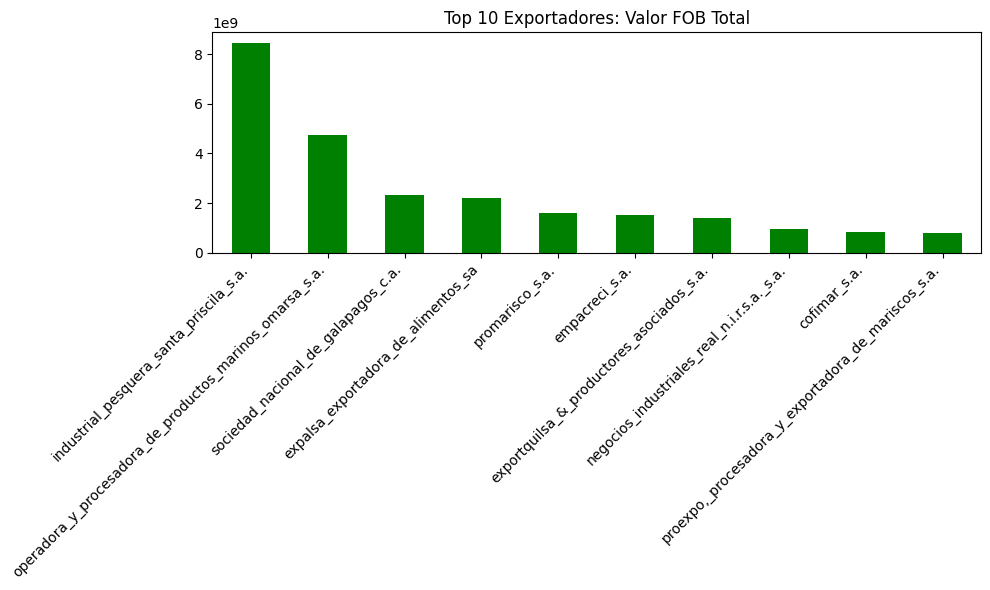


Top 10 Exportadores: Peso por Hectárea
                                 probable_exportador  peso_por_hectarea
4                                    promarisco_s.a.       37884.938247
7         negocios_industriales_real_n.i.r.s.a._s.a.       37017.982656
6          exportquilsa_&_productores_asociados_s.a.       36688.582483
2                sociedad_nacional_de_galapagos_c.a.       36193.946551
9  proexpo,_procesadora_y_exportadora_de_mariscos...       35391.793512
8                                       cofimar_s.a.       34854.730685
1  operadora_y_procesadora_de_productos_marinos_o...       34538.010222
5                                     empacreci_s.a.       34311.917680
0            industrial_pesquera_santa_priscila_s.a.       33374.782361
3                expalsa_exportadora_de_alimentos_sa       31152.250017

Top 10 Exportadores: Cantidad por Hectárea
                                 probable_exportador  cantidad_por_hectarea
2                sociedad_nacional_de_galapagos_

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo CSV generado anteriormente
resumen_exportadores = pd.read_csv('ranking_exportadores.csv')

# Filtrar solo los exportadores presentes en el top 10 por valor total
top_10_valor_total = resumen_exportadores.nlargest(10, 'valor_fob_total')

# Calcular las métricas de eficiencia
top_10_valor_total['peso_por_hectarea'] = (
    top_10_valor_total['peso_neto_total'] / top_10_valor_total['hectareas_aprox']
)
top_10_valor_total['cantidad_por_hectarea'] = (
    top_10_valor_total['cantidad_total'] / top_10_valor_total['hectareas_aprox']
)
top_10_valor_total['valor_por_hectarea'] = (
    top_10_valor_total['valor_fob_total'] / top_10_valor_total['hectareas_aprox']
)

# Graficar el Top 10 General
plt.figure(figsize=(10, 6))
top_10_valor_total.set_index('probable_exportador')['valor_fob_total'].plot(kind='bar', color='green')
plt.title('Top 10 Exportadores: Valor FOB Total')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Reordenar los datos por cada métrica y generar tablas
# Peso por hectárea
top_10_peso = top_10_valor_total.sort_values(by='peso_por_hectarea', ascending=False)
print("\nTop 10 Exportadores: Peso por Hectárea")
print(top_10_peso[['probable_exportador', 'peso_por_hectarea']])

# Cantidad por hectárea
top_10_cantidad = top_10_valor_total.sort_values(by='cantidad_por_hectarea', ascending=False)
print("\nTop 10 Exportadores: Cantidad por Hectárea")
print(top_10_cantidad[['probable_exportador', 'cantidad_por_hectarea']])

# Valor por hectárea
top_10_valor = top_10_valor_total.sort_values(by='valor_por_hectarea', ascending=False)
print("\nTop 10 Exportadores: Valor por Hectárea")
print(top_10_valor[['probable_exportador', 'valor_por_hectarea']])

